# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

USING SGD with lr = 0.001 and momentum = 0.9

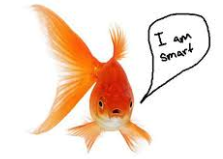

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = '/home/jquach12/jq_shenanigans/data/blackAndWhite_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation','testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

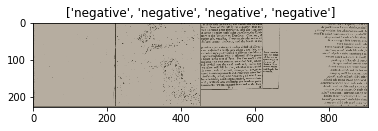

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'validation']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(31360,64).cuda()
        self.fc2 = nn.Linear(64, 25).cuda()
        self.fc3 = nn.Linear(25,2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [9]:
trainLosses = []
valLosses = []

trainAccs = []
valAccs = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    for epoch in range(num_epochs):
        cm_posAndNeg = tnt.meter.ConfusionMeter(2)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    elif phase == 'validation':
                        cm_posAndNeg.add(outputs.data, labels.data)
  
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainLosses.append(epoch_loss)
                trainAccs.append(epoch_acc)
            elif phase == 'validation':
                valLosses.append(epoch_loss)
                valAccs.append(epoch_acc)
                

                print('Confusion matrix:\n', cm_posAndNeg.conf)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model #got really high acc when if phase == 'val' i.e. this never happens
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
net1 = Net1()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.9 every 25 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

In [12]:
num_epochs = 200
net1 = train_model(net1, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 1/200
----------
train Loss: 0.6927 Acc: 0.5190
Confusion matrix:
 [[ 46 122]
 [  5 163]]
validation Loss: 0.6881 Acc: 0.6220

Epoch 2/200
----------
train Loss: 0.6876 Acc: 0.5723
Confusion matrix:
 [[ 97  71]
 [  6 162]]
validation Loss: 0.6793 Acc: 0.7708

Epoch 3/200
----------
train Loss: 0.6760 Acc: 0.5782
Confusion matrix:
 [[123  45]
 [ 18 150]]
validation Loss: 0.6634 Acc: 0.8125

Epoch 4/200
----------
train Loss: 0.6638 Acc: 0.6220
Confusion matrix:
 [[163   5]
 [125  43]]
validation Loss: 0.6522 Acc: 0.6131

Epoch 5/200
----------
train Loss: 0.6435 Acc: 0.6232
Confusion matrix:
 [[122  46]
 [  5 163]]
validation Loss: 0.6150 Acc: 0.8482

Epoch 6/200
----------
train Loss: 0.6540 Acc: 0.6161
Confusion matrix:
 [[132  36]
 [  5 163]]
validation Loss: 0.6121 Acc: 0.8780

Epoch 7/200
----------
train Loss: 0.6406 Acc: 0.6398
Confusion matrix:
 [[168   0]
 [166   2]]
validation Loss: 0.6467 Acc: 0.5060

Epoch 8/200
----------
train Loss: 0.6338 Acc: 0.6517
Confusion matri

Confusion matrix:
 [[132  36]
 [  4 164]]
validation Loss: 0.3721 Acc: 0.8810

Epoch 63/200
----------
train Loss: 0.4488 Acc: 0.8021
Confusion matrix:
 [[137  31]
 [  3 165]]
validation Loss: 0.3884 Acc: 0.8988

Epoch 64/200
----------
train Loss: 0.4699 Acc: 0.7820
Confusion matrix:
 [[137  31]
 [  6 162]]
validation Loss: 0.3807 Acc: 0.8899

Epoch 65/200
----------
train Loss: 0.4632 Acc: 0.7903
Confusion matrix:
 [[134  34]
 [  5 163]]
validation Loss: 0.3780 Acc: 0.8839

Epoch 66/200
----------
train Loss: 0.4550 Acc: 0.7974
Confusion matrix:
 [[138  30]
 [  3 165]]
validation Loss: 0.3393 Acc: 0.9018

Epoch 67/200
----------
train Loss: 0.4428 Acc: 0.8033
Confusion matrix:
 [[137  31]
 [  6 162]]
validation Loss: 0.3667 Acc: 0.8899

Epoch 68/200
----------
train Loss: 0.4706 Acc: 0.7974
Confusion matrix:
 [[124  44]
 [  7 161]]
validation Loss: 0.4676 Acc: 0.8482

Epoch 69/200
----------
train Loss: 0.4642 Acc: 0.7891
Confusion matrix:
 [[134  34]
 [  3 165]]
validation Loss: 0.3

Confusion matrix:
 [[124  44]
 [  3 165]]
validation Loss: 0.4201 Acc: 0.8601

Epoch 124/200
----------
train Loss: 0.4442 Acc: 0.8069
Confusion matrix:
 [[128  40]
 [ 21 147]]
validation Loss: 0.5102 Acc: 0.8185

Epoch 125/200
----------
train Loss: 0.4440 Acc: 0.7962
Confusion matrix:
 [[124  44]
 [  4 164]]
validation Loss: 0.4201 Acc: 0.8571

Epoch 126/200
----------
train Loss: 0.4256 Acc: 0.8069
Confusion matrix:
 [[114  54]
 [  2 166]]
validation Loss: 0.4356 Acc: 0.8333

Epoch 127/200
----------
train Loss: 0.4082 Acc: 0.8258
Confusion matrix:
 [[133  35]
 [ 16 152]]
validation Loss: 0.4316 Acc: 0.8482

Epoch 128/200
----------
train Loss: 0.4032 Acc: 0.8246
Confusion matrix:
 [[128  40]
 [  8 160]]
validation Loss: 0.4392 Acc: 0.8571

Epoch 129/200
----------
train Loss: 0.4245 Acc: 0.8081
Confusion matrix:
 [[131  37]
 [ 29 139]]
validation Loss: 0.4688 Acc: 0.8036

Epoch 130/200
----------
train Loss: 0.4084 Acc: 0.8128
Confusion matrix:
 [[129  39]
 [  2 166]]
validation Lo

train Loss: 0.4002 Acc: 0.8246
Confusion matrix:
 [[116  52]
 [ 10 158]]
validation Loss: 0.4573 Acc: 0.8155

Epoch 185/200
----------
train Loss: 0.3980 Acc: 0.8258
Confusion matrix:
 [[131  37]
 [ 56 112]]
validation Loss: 0.5575 Acc: 0.7232

Epoch 186/200
----------
train Loss: 0.3960 Acc: 0.8270
Confusion matrix:
 [[127  41]
 [ 22 146]]
validation Loss: 0.4721 Acc: 0.8125

Epoch 187/200
----------
train Loss: 0.4063 Acc: 0.8258
Confusion matrix:
 [[134  34]
 [ 46 122]]
validation Loss: 0.5002 Acc: 0.7619

Epoch 188/200
----------
train Loss: 0.3976 Acc: 0.8270
Confusion matrix:
 [[129  39]
 [ 10 158]]
validation Loss: 0.3897 Acc: 0.8542

Epoch 189/200
----------
train Loss: 0.3977 Acc: 0.8164
Confusion matrix:
 [[130  38]
 [ 27 141]]
validation Loss: 0.4686 Acc: 0.8065

Epoch 190/200
----------
train Loss: 0.4202 Acc: 0.8057
Confusion matrix:
 [[129  39]
 [ 22 146]]
validation Loss: 0.4374 Acc: 0.8185

Epoch 191/200
----------
train Loss: 0.3774 Acc: 0.8389
Confusion matrix:
 [[141

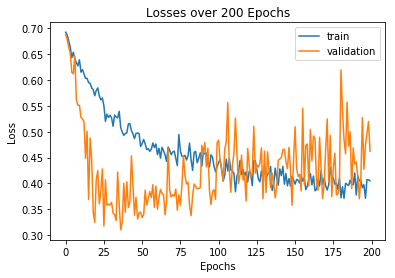

Statistics after 50-200 (where model is a little more robust since 50 epochs have passed)

Average Training Loss: 0.4253
Average Validation Loss: 0.4260

Lowest Training Loss found: 0.3711
Lowest Validation Loss found: 0.3338

Average Training Accuracy: 0.8103
Average Validation Accuracy: 0.8437

Highest Training Accuracy found: 0.8412
Highest Validation Accuracy found: 0.9018


In [13]:
plt.plot(trainLosses,label = "train")
plt.plot(valLosses,label = "validation")
plt.title("Losses over " + str(num_epochs) +  " Epochs")
plt.ylabel('Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

print("Statistics after 50-200 (where model is a little more robust since 50 epochs have passed)")
print()
print("Average Training Loss: {:.4f}".format(np.mean(trainLosses[50:])))
print("Average Validation Loss: {:.4f}".format(np.mean(valLosses[50:])))
print()
print("Lowest Training Loss found: {:.4f}".format(np.min(trainLosses[50:])))
print("Lowest Validation Loss found: {:.4f}".format(np.min(valLosses[50:])))
print()
print("Average Training Accuracy: {:.4f}".format(np.mean(trainAccs[50:])))
print("Average Validation Accuracy: {:.4f}".format(np.mean(valAccs[50:])))
print()
print("Highest Training Accuracy found: {:.4f}".format(np.max(trainAccs[50:])))
print("Highest Validation Accuracy found: {:.4f}".format(np.max(valAccs[50:])))

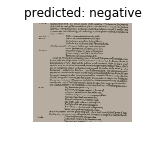

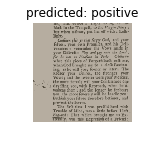

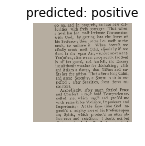

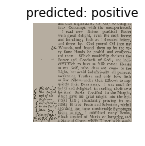

In [14]:
visualize_model(net1,4)

plt.ioff()
plt.show()

In [15]:
#torch.save(net1.state_dict(), '/home/jquach12/net1_weight200ep.pt')
#torch.save(net1, '/home/jquach12/net1_model200ep.pt')